In [31]:
import utils
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

checkpoint_path = 'weights/checkpoint_MLP.pth'
RESUME_TRAINING = False

PRINT_IMG = True
AUGMENT_DATASET = True
TRANSFORM_DATASET = False

OPTIMIZER='SGD'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.00012
MOMENTUM = 0.9
EPOCHS = 15

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 5

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
train_dataset_imbalanced, _ = utils.create_train_dataset_imbalanced(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset_imbalanced, validation_dataset_imbalanced, _ = utils.create_test_dataset_imbalanced(validation_split=0.3)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000
Dimensione del dataset combinato: 120000


Numero totale di campioni: 120000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 53770, 1: 54397, 2: 11833}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 53770 campioni (44.81%)
Relazione 1: 54397 campioni (45.33%)
Relazione 2: 11833 campioni (9.86%)




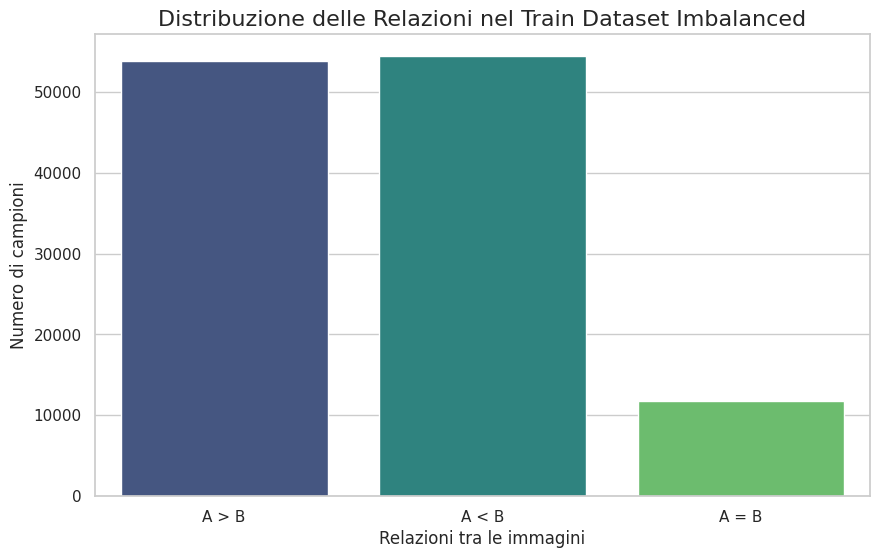

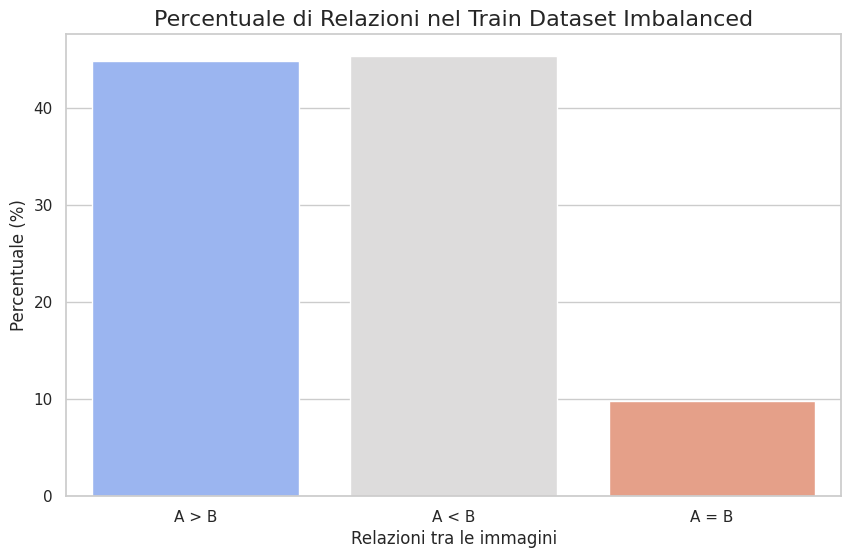

In [3]:
utils.plot_dataset_statistics(train_dataset_imbalanced, "Train Dataset Imbalanced")

Numero totale di campioni: 7000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 3153, 1: 3164, 2: 683}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 3153 campioni (45.04%)
Relazione 1: 3164 campioni (45.20%)
Relazione 2: 683 campioni (9.76%)




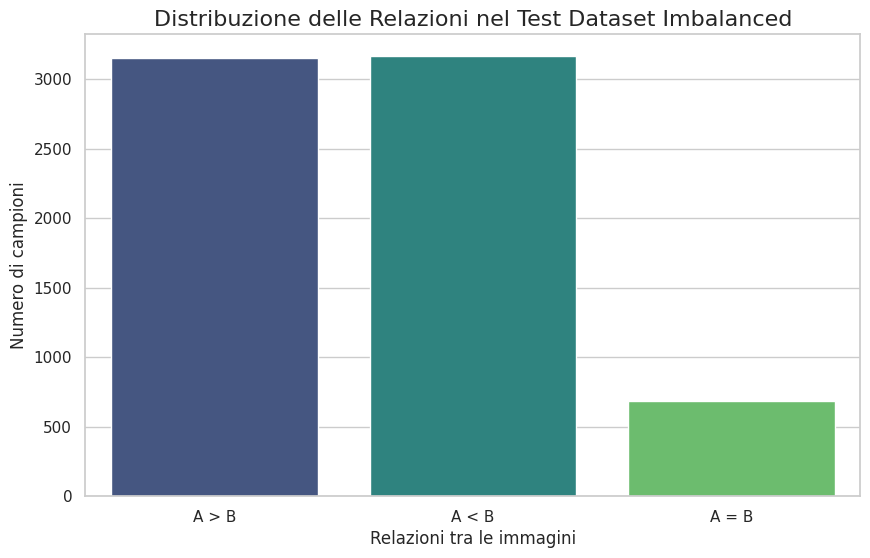

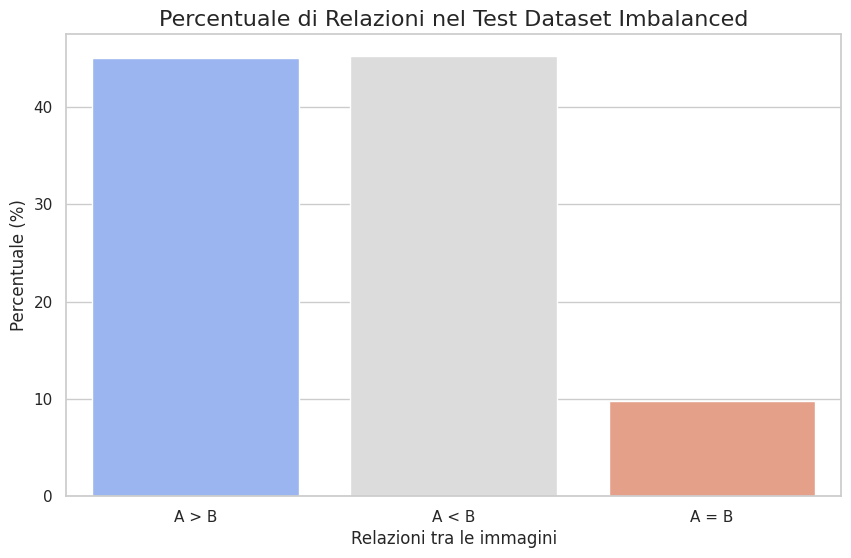

In [4]:
utils.plot_dataset_statistics(test_dataset_imbalanced, "Test Dataset Imbalanced")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 1356, 1: 1361, 2: 283}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 1356 campioni (45.20%)
Relazione 1: 1361 campioni (45.37%)
Relazione 2: 283 campioni (9.43%)




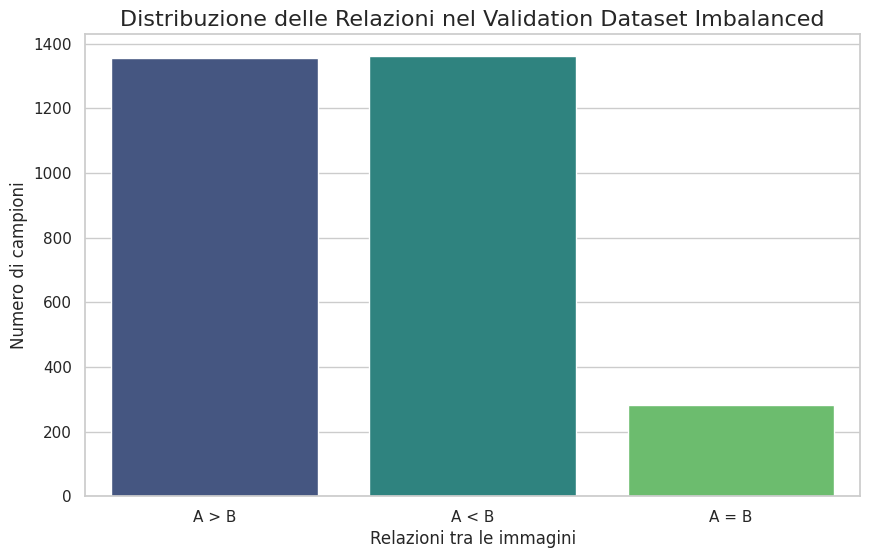

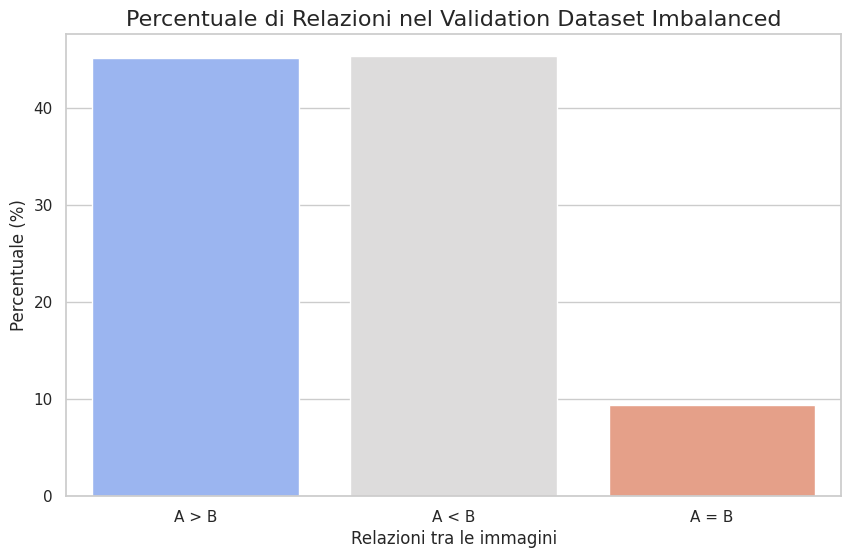

In [5]:
utils.plot_dataset_statistics(validation_dataset_imbalanced, "Validation Dataset Imbalanced")

In [6]:
train_dataset, train_dataset_raw = utils.create_train_dataset_MLP(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset, validation_dataset, test_dataset_raw = utils.create_test_dataset_MLP(validation_split=0.7)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000
Dimensione del dataset combinato: 120000


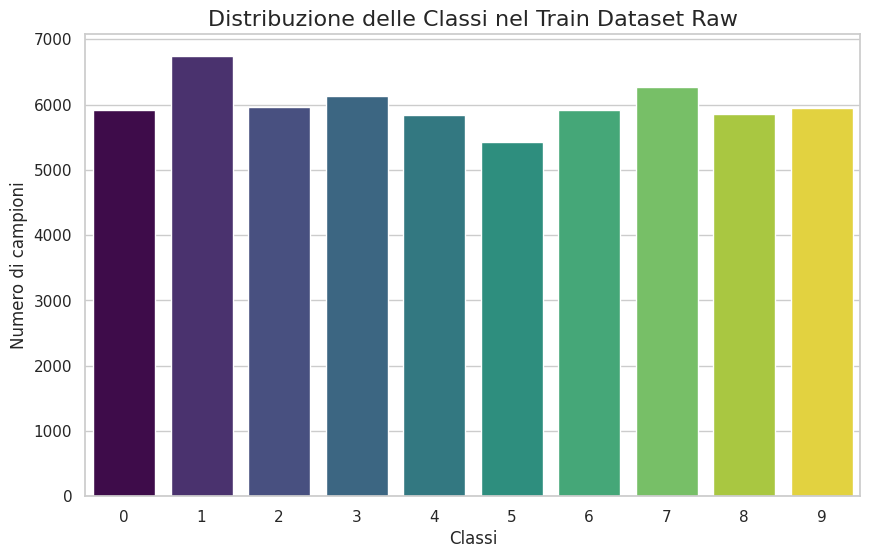

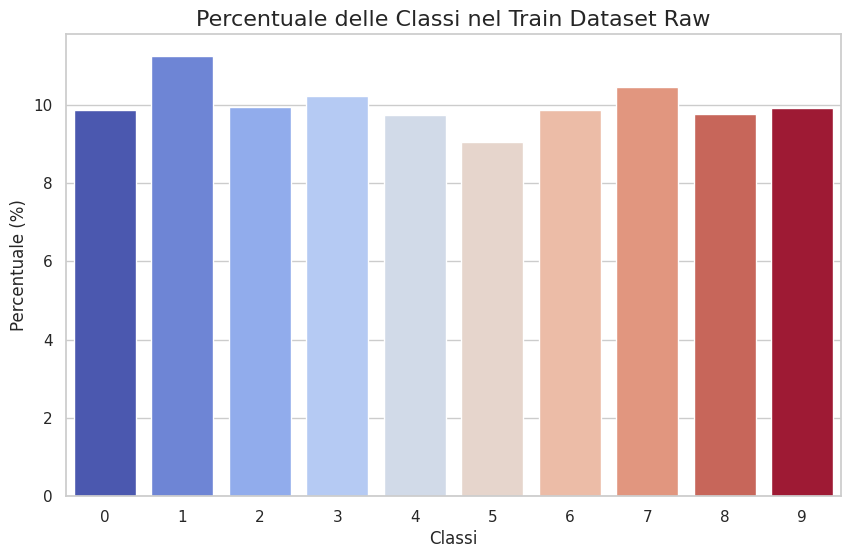

In [7]:
utils.plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 120000
Distribuzione delle relazioni (A > B, A < B, A = B): {2: 40000, 1: 40000, 0: 40000}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 2: 40000 campioni (33.33%)
Relazione 1: 40000 campioni (33.33%)
Relazione 0: 40000 campioni (33.33%)




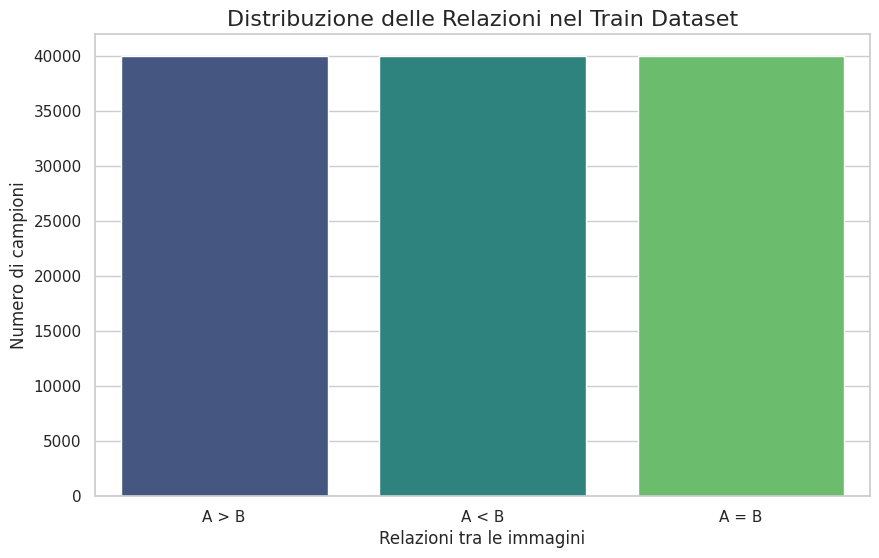

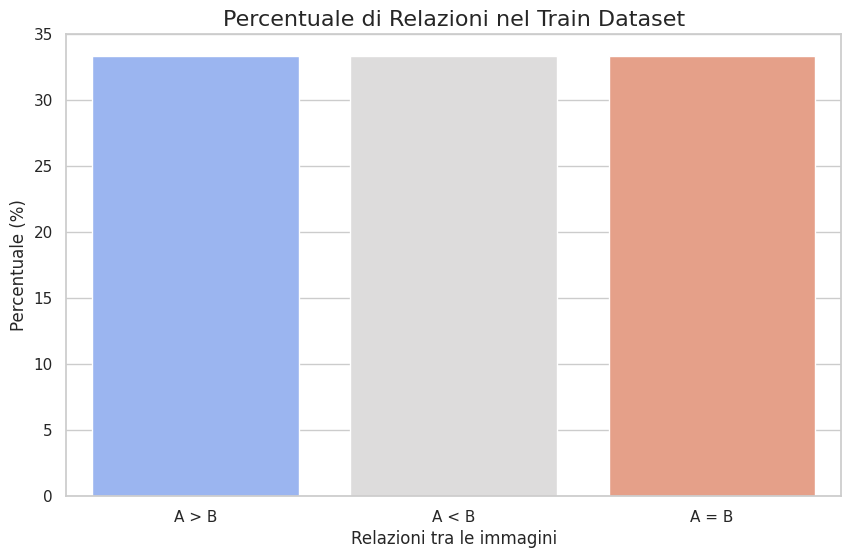

In [8]:
utils.plot_dataset_statistics_MLP(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 989, 2: 1015, 1: 996}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 0: 989 campioni (32.97%)
Relazione 2: 1015 campioni (33.83%)
Relazione 1: 996 campioni (33.20%)




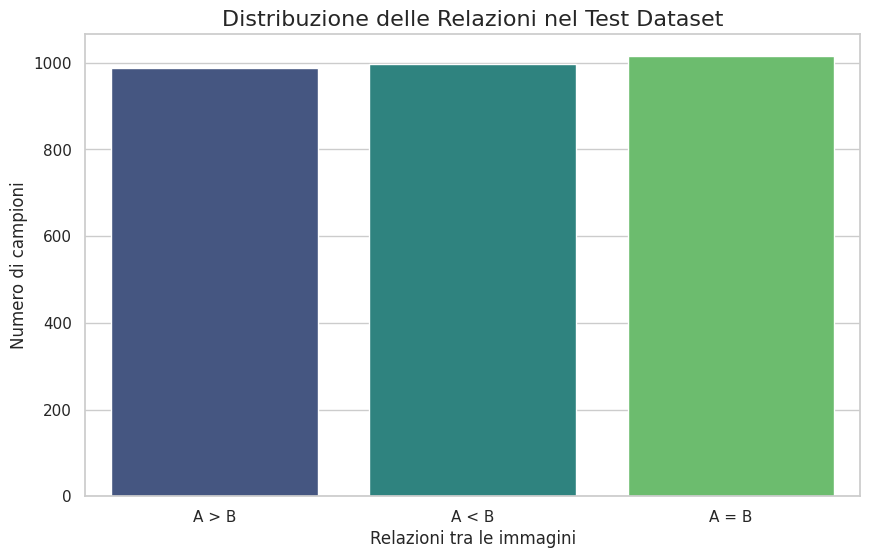

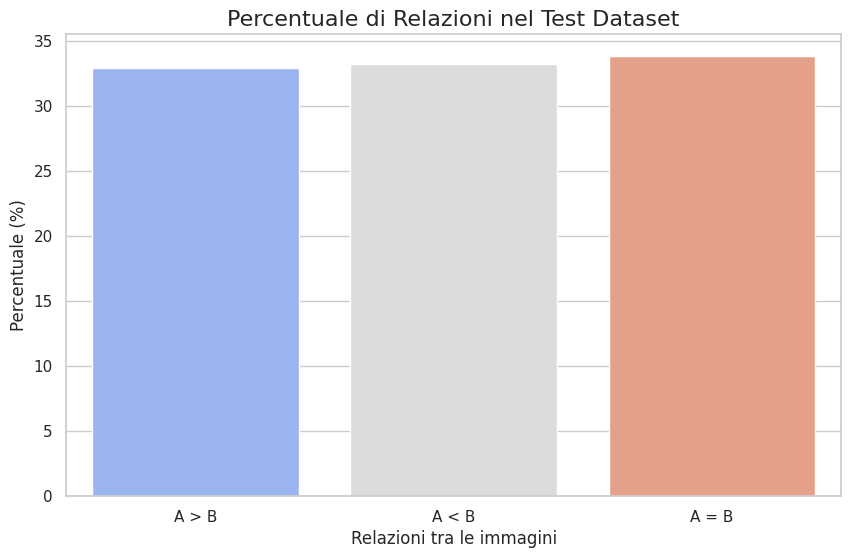

In [9]:
utils.plot_dataset_statistics_MLP(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 6999
Distribuzione delle relazioni (A > B, A < B, A = B): {2: 2318, 1: 2337, 0: 2344}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 2: 2318 campioni (33.12%)
Relazione 1: 2337 campioni (33.39%)
Relazione 0: 2344 campioni (33.49%)




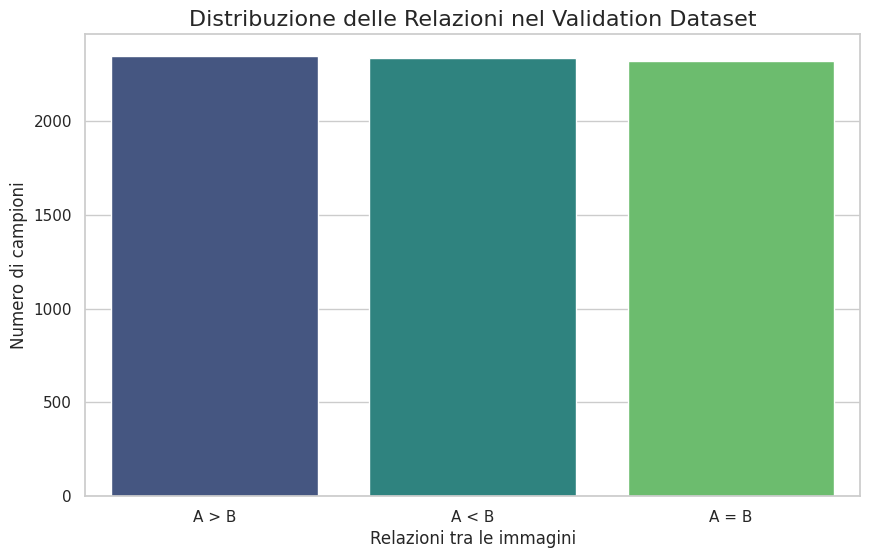

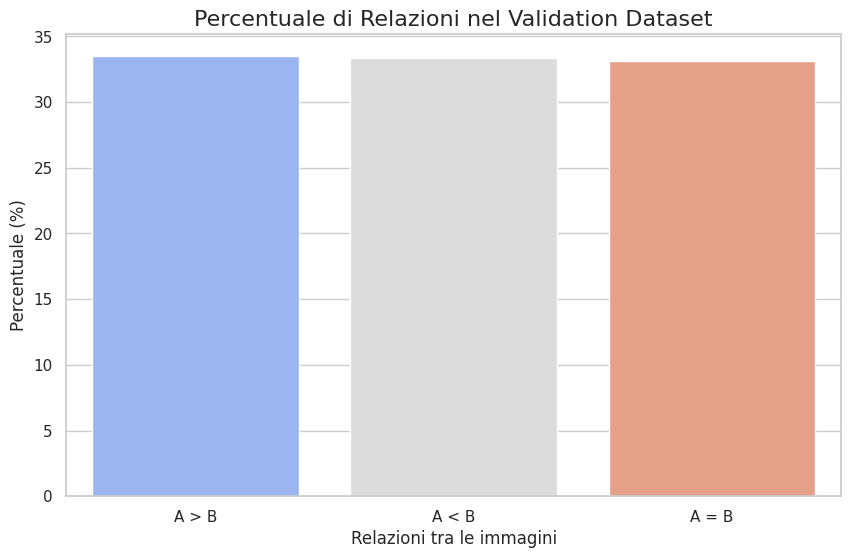

In [10]:
utils.plot_dataset_statistics_MLP(validation_dataset, dataset_name="Validation Dataset")

In [11]:
train_loader, validation_loader, test_loader = utils.create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [12]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  938  Size train_dataset:  120000
Size validation_loader:  55  Size validation_dataset:  6999
Size test_loader:  24  Size test_dataset:  3000


In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [33]:
import torch.nn as nn
import torch.nn.functional as F

class NumberRecognitionCNN(nn.Module):
    def __init__(self):
        super(NumberRecognitionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # Singola immagine, quindi 1 canale
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 classi per i numeri da 0 a 9

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output con 10 classi (softmax potrebbe essere applicato esternamente)
        return x


In [34]:
class ComparisonMLP(nn.Module):
    def __init__(self):
        super(ComparisonMLP, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Prende 2 numeri in input
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)  # 3 classi (A > B, A < B, A = B)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output con 3 classi
        return x


In [35]:
class NumberComparisonModel(nn.Module):
    def __init__(self):
        super(NumberComparisonModel, self).__init__()
        self.cnn = NumberRecognitionCNN()  # Modello CNN per il riconoscimento dei numeri
        self.mlp = ComparisonMLP()  # MLP per confrontare i due numeri

    def load_cnn_weights(self, path):
        # Caricare i pesi della CNN da un file salvato
        self.cnn.load_state_dict(torch.load(path))
        # Bloccare i gradienti della CNN per non addestrarla nuovamente
        for param in self.cnn.parameters():
            param.requires_grad = False

    def forward(self, img1: torch.Tensor, img2: torch.Tensor):
        # Riconoscimento del numero in ciascuna immagine
        num1 = self.cnn(img1)
        num2 = self.cnn(img2)

        # Convertire l'output della CNN in numeri predetti
        num1 = F.softmax(num1, dim=1).argmax(dim=1)
        num2 = F.softmax(num2, dim=1).argmax(dim=1)

        # Convertire i numeri in tensori float per il confronto
        num1 = num1.float()
        num2 = num2.float()

        # Combinare i numeri riconosciuti per passarli alla MLP
        numbers = torch.stack((num1, num2), dim=1)
        comparison = self.mlp(numbers)
        
        return num1, num2, comparison


In [36]:
model = NumberComparisonModel()

model.load_cnn_weights('weights/lenet5_best_weights.pth')
model.to(device)

criterion = nn.CrossEntropyLoss()

if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.mlp.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.mlp.parameters(), lr=LEARNING_RATE)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

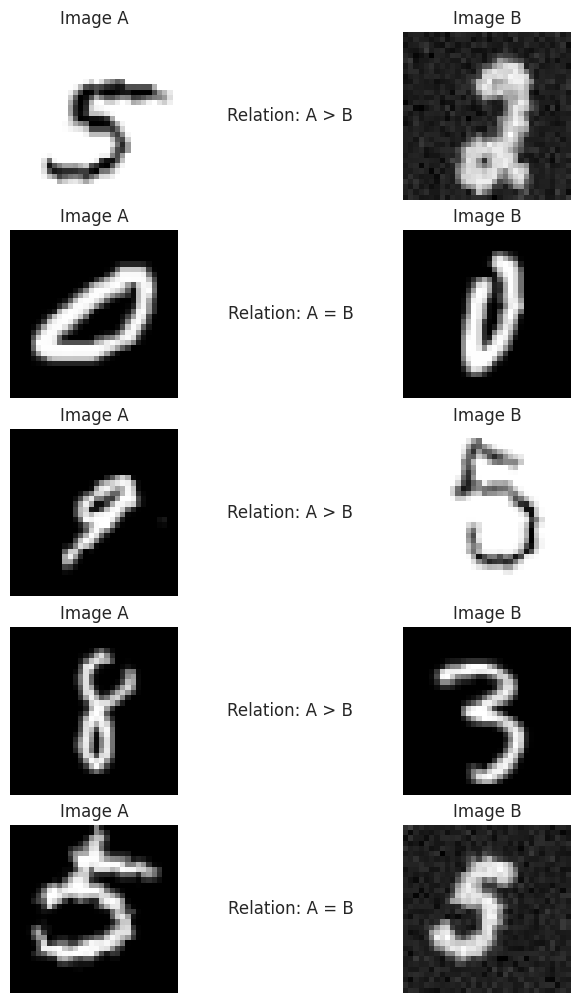

In [37]:
from torch.utils.tensorboard import SummaryWriter

# Definisci il fileName in base all'ottimizzatore
if OPTIMIZER == 'SGD':
    fileName = f"runs/logMLP_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/logMLP_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottieni un batch dal dataloader
batch = next(iter(train_loader))
imgs_A, imgs_B, labels = batch

# Dividi il batch in due immagini (img_A e img_B)
img_A, img_B = imgs_A[0], imgs_B[0]

# Ensure both tensors are of the same dtype
img_A = img_A.to(device)
img_B = img_B.to(device)

# Aggiungi entrambi gli input al grafo del modello
writer.add_graph(model, (img_A, img_B))

# Visualizza un esempio di coppia di immagini
writer.add_figure('Image_pair', utils.show_dataset_MLP(train_loader, 5))


In [38]:
def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        img_A, img_B, labels = data

        img_A, img_B, labels = img_A.to(device), img_B.to(device), labels.to(device)

        optimizer.zero_grad()

        num1, num2, outputs = model(img_A, img_B)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        img_A, img_B, labels = data

        img_A, img_B, labels = img_A.to(device), img_B.to(device), labels.to(device)
        
        with torch.no_grad():
            num1, num2, outputs = model(img_A, img_B)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [39]:
start_epoch = 0
if RESUME_TRAINING and os.path.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = utils.load_checkpoint(model, optimizer, scheduler, checkpoint_path)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
learning_rates = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        # start timer and carry out training and validation
        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalar('Learning Rate', current_lr, epoch + 1)
        #writer.add_scalar('Train Loss', train_loss, epoch + 1)
        #writer.add_scalar('Validation Loss', val_loss, epoch + 1)
        #writer.add_scalar('Train Accuracy', train_acc, epoch + 1)
        #writer.add_scalar('Validation Accuracy', val_acc, epoch + 1)
        
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)
        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)
                        break

        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 15
Training


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 0.9252: 100%|██████████| 938/938 [00:17<00:00, 52.95it/s]


Validating


Loss: 0.7151: 100%|██████████| 55/55 [00:00<00:00, 62.97it/s]


Epoch #1 train loss: 0.908 train accuracy: 71.04
Epoch #1 validation loss: 0.715 validation accuracy: 92.30
Learning rate actual:  0.00012
Took 0.310 minutes for epoch 1
Checkpoint saved at epoch 1.

EPOCH 2 of 15
Training


Loss: 0.8136: 100%|██████████| 938/938 [00:18<00:00, 49.46it/s]


Validating


Loss: 0.6479: 100%|██████████| 55/55 [00:01<00:00, 45.54it/s]


Epoch #2 train loss: 0.832 train accuracy: 75.28
Epoch #2 validation loss: 0.648 validation accuracy: 91.58
Learning rate actual:  0.00012
Took 0.336 minutes for epoch 2
Checkpoint saved at epoch 2.

EPOCH 3 of 15
Training


Loss: 0.8372: 100%|██████████| 938/938 [00:20<00:00, 46.34it/s]


Validating


Loss: 0.6192: 100%|██████████| 55/55 [00:01<00:00, 45.79it/s]


Epoch #3 train loss: 0.813 train accuracy: 75.27
Epoch #3 validation loss: 0.619 validation accuracy: 91.58
Learning rate actual:  0.00012
Took 0.358 minutes for epoch 3
Checkpoint saved at epoch 3.

EPOCH 4 of 15
Training


Loss: 0.7168: 100%|██████████| 938/938 [00:20<00:00, 45.67it/s]


Validating


Loss: 0.5970: 100%|██████████| 55/55 [00:01<00:00, 48.49it/s]


Epoch #4 train loss: 0.799 train accuracy: 75.06
Epoch #4 validation loss: 0.597 validation accuracy: 90.78
Learning rate actual:  0.00012
Took 0.361 minutes for epoch 4
Checkpoint saved at epoch 4.

EPOCH 5 of 15
Training


Loss: 0.8111: 100%|██████████| 938/938 [00:20<00:00, 45.99it/s]


Validating


Loss: 0.5785: 100%|██████████| 55/55 [00:01<00:00, 51.82it/s]


Epoch #5 train loss: 0.787 train accuracy: 74.77
Epoch #5 validation loss: 0.579 validation accuracy: 90.13
Learning rate actual:  0.00012
Took 0.358 minutes for epoch 5
Checkpoint saved at epoch 5.

EPOCH 6 of 15
Training


Loss: 0.8842: 100%|██████████| 938/938 [00:19<00:00, 47.80it/s]


Validating


Loss: 0.5567: 100%|██████████| 55/55 [00:01<00:00, 46.58it/s]


Epoch #6 train loss: 0.777 train accuracy: 74.55
Epoch #6 validation loss: 0.557 validation accuracy: 89.94
Learning rate actual:  0.00012
Took 0.347 minutes for epoch 6
Checkpoint saved at epoch 6.

EPOCH 7 of 15
Training


Loss: 0.7926: 100%|██████████| 938/938 [00:20<00:00, 46.37it/s]


Validating


Loss: 0.5408: 100%|██████████| 55/55 [00:01<00:00, 43.32it/s]


Epoch #7 train loss: 0.768 train accuracy: 74.06
Epoch #7 validation loss: 0.541 validation accuracy: 89.28
Learning rate actual:  0.00012
Took 0.359 minutes for epoch 7
Checkpoint saved at epoch 7.

EPOCH 8 of 15
Training


Loss: 0.7009: 100%|██████████| 938/938 [00:20<00:00, 45.97it/s]


Validating


Loss: 0.5239: 100%|██████████| 55/55 [00:01<00:00, 47.61it/s]


Epoch #8 train loss: 0.759 train accuracy: 74.07
Epoch #8 validation loss: 0.524 validation accuracy: 89.94
Learning rate actual:  0.00012
Took 0.360 minutes for epoch 8
Checkpoint saved at epoch 8.

EPOCH 9 of 15
Training


Loss: 0.8504: 100%|██████████| 938/938 [00:20<00:00, 46.52it/s]


Validating


Loss: 0.5078: 100%|██████████| 55/55 [00:01<00:00, 49.47it/s]


Epoch #9 train loss: 0.752 train accuracy: 74.09
Epoch #9 validation loss: 0.508 validation accuracy: 89.94
Learning rate actual:  0.00012
Took 0.355 minutes for epoch 9
Checkpoint saved at epoch 9.

EPOCH 10 of 15
Training


Loss: 0.7273: 100%|██████████| 938/938 [00:20<00:00, 46.54it/s]


Validating


Loss: 0.4926: 100%|██████████| 55/55 [00:00<00:00, 56.34it/s]


Epoch #10 train loss: 0.744 train accuracy: 74.08
Epoch #10 validation loss: 0.493 validation accuracy: 86.58
Learning rate actual:  0.00012
Took 0.352 minutes for epoch 10
Checkpoint saved at epoch 10.

EPOCH 11 of 15
Training


Loss: 0.7727: 100%|██████████| 938/938 [00:19<00:00, 49.04it/s]


Validating


Loss: 0.4802: 100%|██████████| 55/55 [00:00<00:00, 56.86it/s]


Epoch #11 train loss: 0.738 train accuracy: 73.64
Epoch #11 validation loss: 0.480 validation accuracy: 89.47
Learning rate actual:  0.00012
Took 0.335 minutes for epoch 11
Checkpoint saved at epoch 11.

EPOCH 12 of 15
Training


Loss: 0.7669: 100%|██████████| 938/938 [00:18<00:00, 50.17it/s]


Validating


Loss: 0.4703: 100%|██████████| 55/55 [00:00<00:00, 61.69it/s]


Epoch #12 train loss: 0.731 train accuracy: 73.72
Epoch #12 validation loss: 0.470 validation accuracy: 89.47
Learning rate actual:  0.00012
Took 0.327 minutes for epoch 12
Checkpoint saved at epoch 12.

EPOCH 13 of 15
Training


Loss: 0.5938: 100%|██████████| 938/938 [00:16<00:00, 55.79it/s]


Validating


Loss: 0.4554: 100%|██████████| 55/55 [00:00<00:00, 62.98it/s]


Epoch #13 train loss: 0.725 train accuracy: 74.10
Epoch #13 validation loss: 0.455 validation accuracy: 90.14
Learning rate actual:  0.00012
Took 0.295 minutes for epoch 13
Checkpoint saved at epoch 13.

EPOCH 14 of 15
Training


Loss: 0.6089: 100%|██████████| 938/938 [00:16<00:00, 55.49it/s]


Validating


Loss: 0.4463: 100%|██████████| 55/55 [00:01<00:00, 48.48it/s]


Epoch #14 train loss: 0.719 train accuracy: 74.65
Epoch #14 validation loss: 0.446 validation accuracy: 91.43
Learning rate actual:  0.00012
Took 0.301 minutes for epoch 14
Checkpoint saved at epoch 14.

EPOCH 15 of 15
Training


Loss: 0.7007: 100%|██████████| 938/938 [00:20<00:00, 46.77it/s]


Validating


Loss: 0.4345: 100%|██████████| 55/55 [00:01<00:00, 48.19it/s]


Epoch #15 train loss: 0.714 train accuracy: 75.29
Epoch #15 validation loss: 0.434 validation accuracy: 91.43
Learning rate actual:  0.00012
Took 0.353 minutes for epoch 15
Checkpoint saved at epoch 15.
Validating


Loss: 0.3302: 100%|██████████| 24/24 [00:00<00:00, 49.79it/s]

Test loss: 0.330 Test accuracy: 91.83


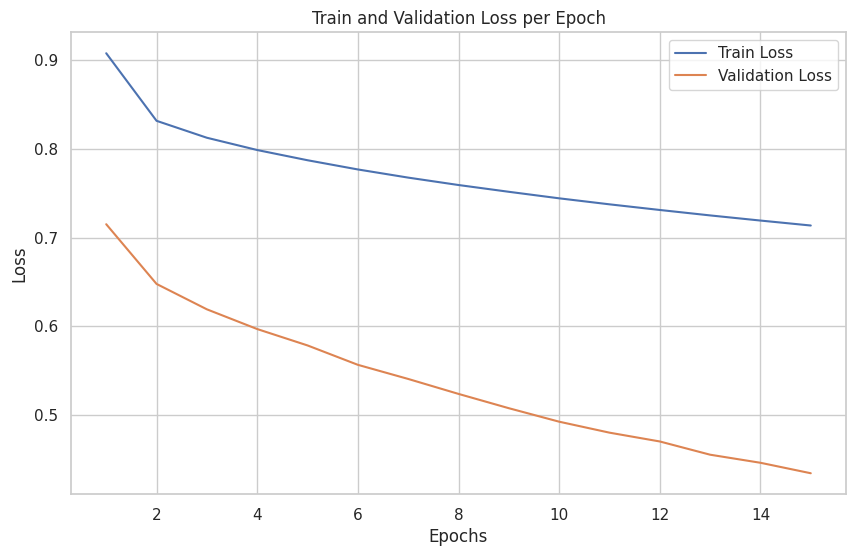

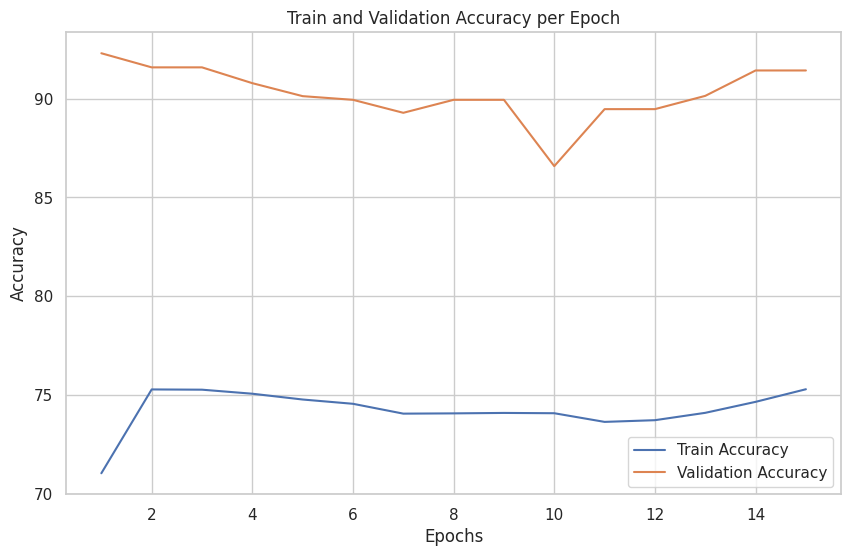

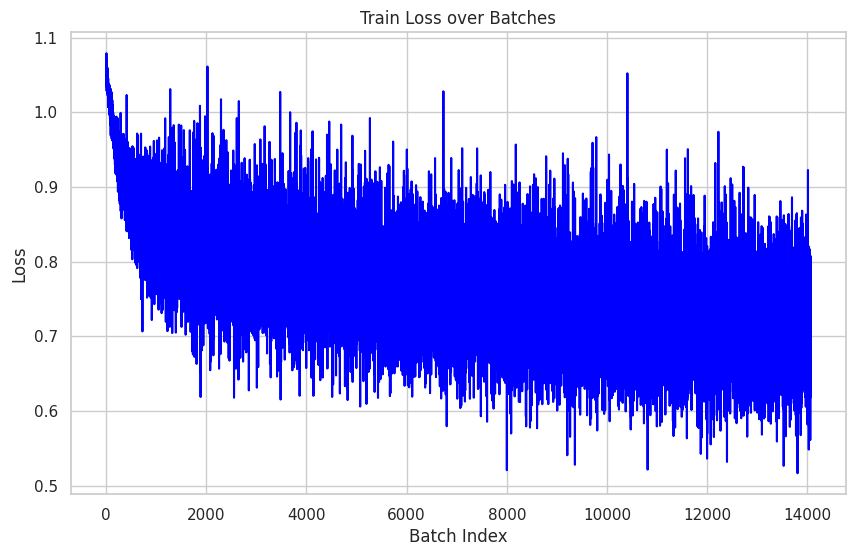

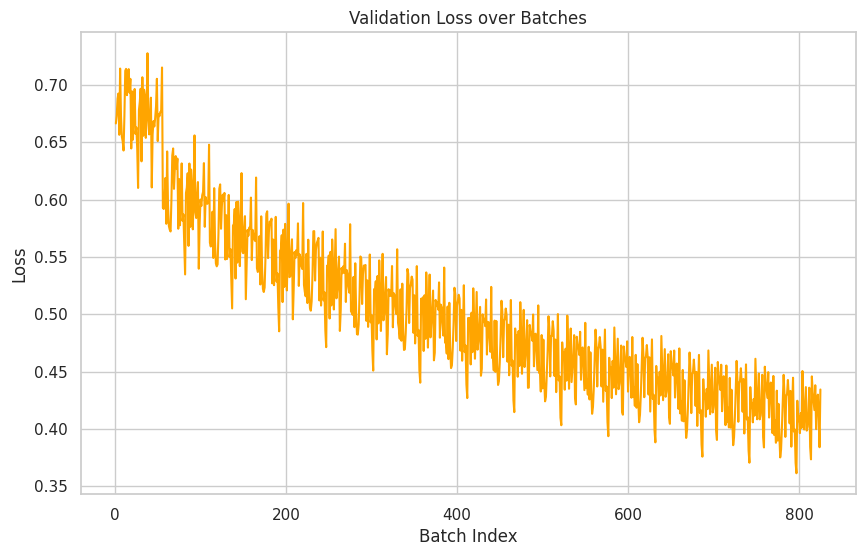

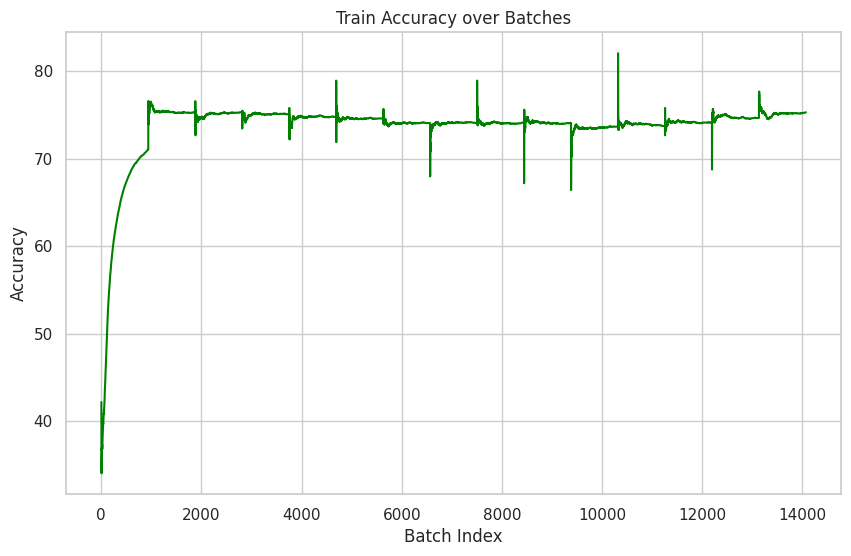

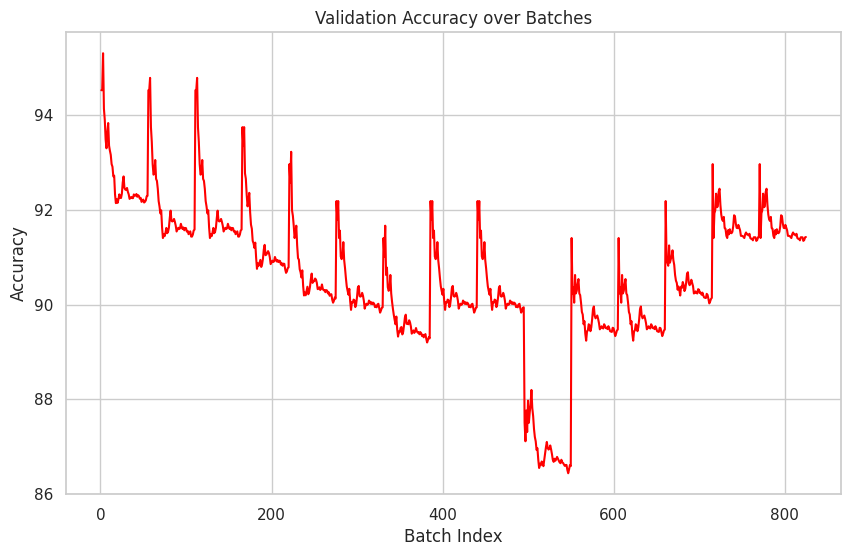

In [40]:
utils.plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

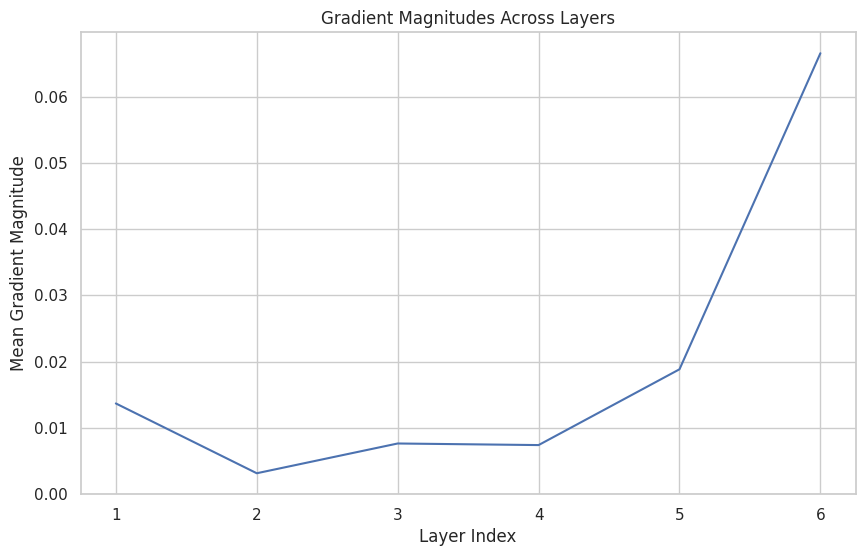

In [41]:
utils.plot_gradient(model)

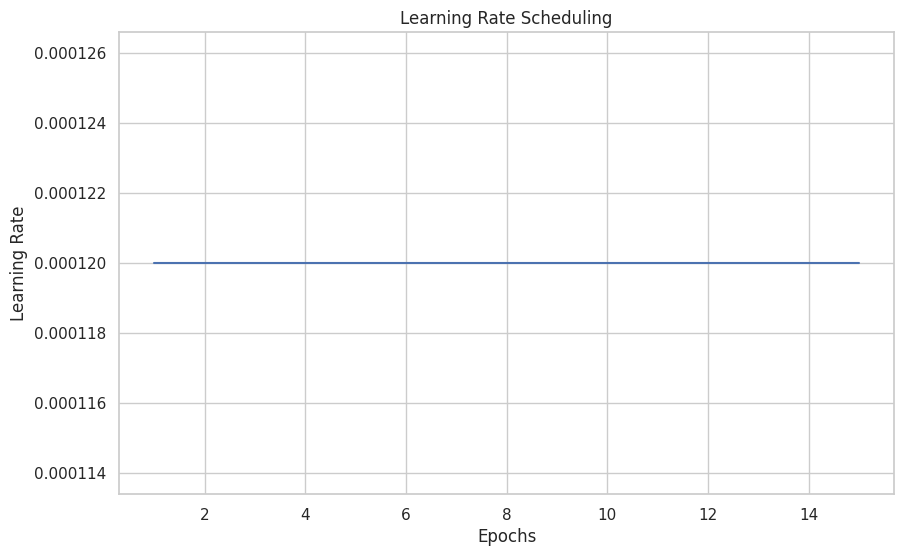

In [42]:
utils.plot_lr_scheduler(learning_rates)

In [43]:
all_preds_test, all_labels_test, all_images_A_test, all_images_B_test, all_num1_preds_test, all_num2_preds_test = utils.inference_MLP(model, test_loader, device)
all_preds_val, all_labels_val, all_images_A_val, all_images_B_val, all_num1_preds_val, all_num2_preds_val = utils.inference_MLP(model, validation_loader, device)

245 previsioni errate trovate.


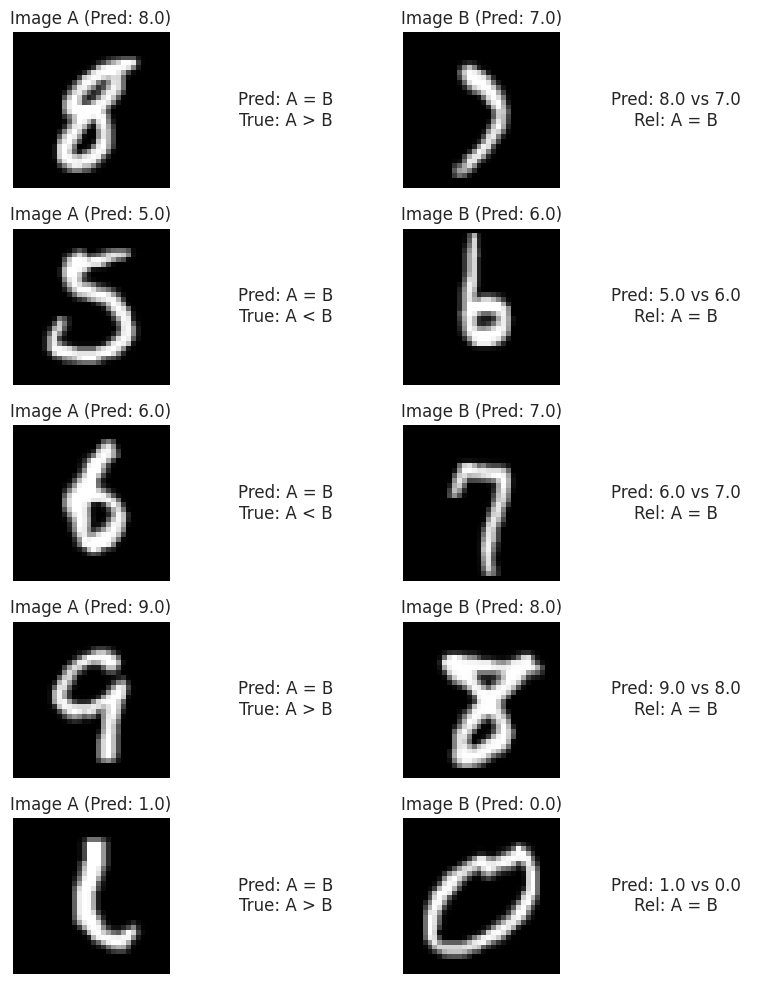

In [44]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_test', utils.show_incorrect_predictions_MLP(all_preds_test, all_labels_test, all_images_A_test, all_images_B_test, all_num1_preds_test, all_num2_preds_test, 5))

In [ ]:
writer.add_figure('Incorrect_predictions_val', utils.show_incorrect_predictions_MLP(all_preds_val, all_labels_val, all_images_A_val, all_images_B_val, all_num1_preds_val, all_num2_preds_val, 5))

600 previsioni errate trovate.


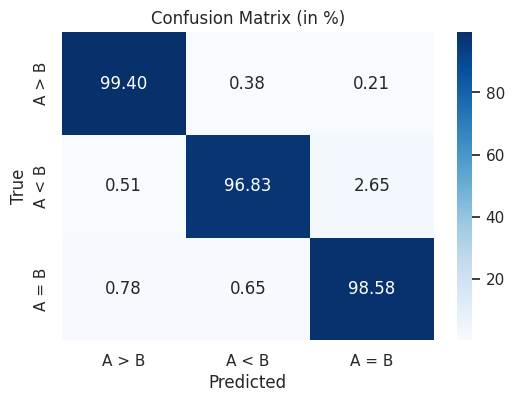

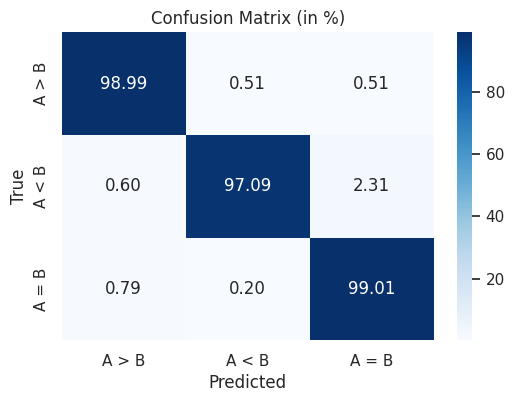

In [ ]:
# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', utils.plot_confusion_matrix(all_preds_val, all_labels_val))
writer.add_figure('Confusion_matrix_test', utils.plot_confusion_matrix(all_preds_test, all_labels_test))
#plot_confusion_matrix(model, test_loader, device)


In [ ]:
# Stampa il report delle metriche
utils.classification_metrics(all_preds_test, all_labels_test)


              precision    recall  f1-score   support

       A > B       0.99      0.99      0.99       989
       A < B       0.99      0.97      0.98       996
       A = B       0.97      0.99      0.98      1015

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [ ]:
# Funzione per salvare una copia del notebook
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    if OPTIMIZER == 'SGD':
        new_notebook_name = f"runMLP_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    elif OPTIMIZER == 'ADAM':
        new_notebook_name = f"runMLP_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    
    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    print(f"Notebook saved as {new_notebook_name}")

# Specifica il nome del notebook attuale
save_notebook_copy('main_MLP.ipynb')


Notebook saved as runMLP_BS=128_LR=2.5e-05_EPOCHS=15_AUG=True_TRA=False_OPT=ADAM.ipynb


In [ ]:
writer.close()